<a href="https://colab.research.google.com/github/rafaelmgr12/ds-projects/blob/main/Titanic/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Machine Learning from Disaster
Start here! Predict survival on the Titanic and get familiar with ML basics

## Data Desription



Overview
The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Data Dictionary
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! wget https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/ml_functions.py -O ml_functions.py
  ! wget https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/plots_functions.py -O plot_functions.py
  ! pip install bayesian-optimization
  ! pip install squarify
  ! pip install sentencepiece
  ! pip install unidecode
  ! pip install category-encoders
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle competitions download -c titanic

Saving kaggle.json to kaggle.json
--2021-07-14 16:48:10--  https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/ml_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6651 (6.5K) [text/plain]
Saving to: ‘ml_functions.py’

ml_functions.py     100%[===================>]   6.50K  --.-KB/s    in 0s      

2021-07-14 16:48:10 (74.4 MB/s) - ‘ml_functions.py’ saved [6651/6651]

--2021-07-14 16:48:11--  https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/plots_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awai

In [ ]:
import pandas as pd
import numpy as np
import warnings 

import ml_functions as ml
import plot_functions as plf

warnings.filterwarnings("ignore")

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify
import plotly.io as pio
pio.renderers.default = 'colab'

import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
# Stats
import scipy.stats as ss
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('ggplot')

%matplotlib inline

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
combine = [train,test]

In [ ]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
417,418,1,2,"Silven, Miss. Lyyli Karoliina",female,18.0,0,2,250652,13.0000,NaN,S
752,753,0,3,"Vande Velde, Mr. Johannes Joseph",male,33.0,0,0,345780,9.5000,NaN,S
834,835,0,3,"Allum, Mr. Owen George",male,18.0,0,0,2223,8.3000,NaN,S
490,491,0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,19.9667,NaN,S
368,369,1,3,"Jermyn, Miss. Annie",female,NaN,0,0,14313,7.7500,NaN,Q


In [ ]:
test.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
11,903,1,"Jones, Mr. Charles Cresson",male,46.0,0,0,694,26.0000,NaN,S
52,944,2,"Hocking, Miss. Ellen Nellie""""",female,20.0,2,1,29105,23.0000,NaN,S
85,977,3,"Khalil, Mr. Betros",male,NaN,1,0,2660,14.4542,NaN,C
143,1035,2,"Beauchamp, Mr. Henry James",male,28.0,0,0,244358,26.0000,NaN,S
367,1259,3,"Riihivouri, Miss. Susanna Juhantytar Sanni""""",female,22.0,0,0,3101295,39.6875,NaN,S


## EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [ ]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [ ]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


### Data Visualization




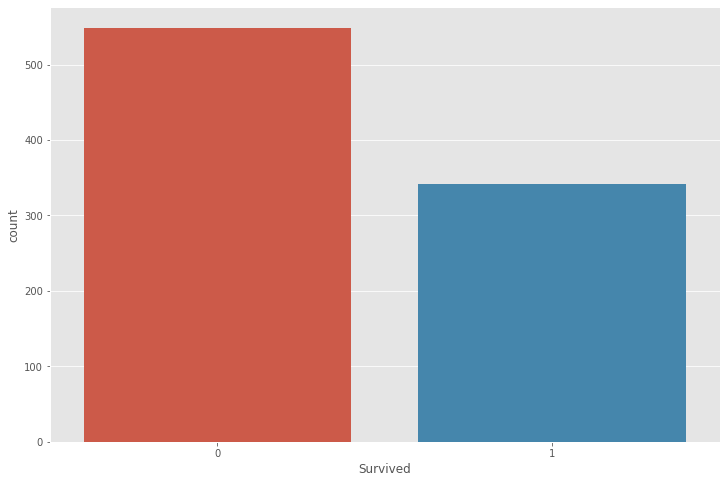

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x='Survived', data = train)

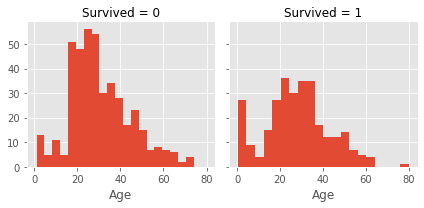

In [ ]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

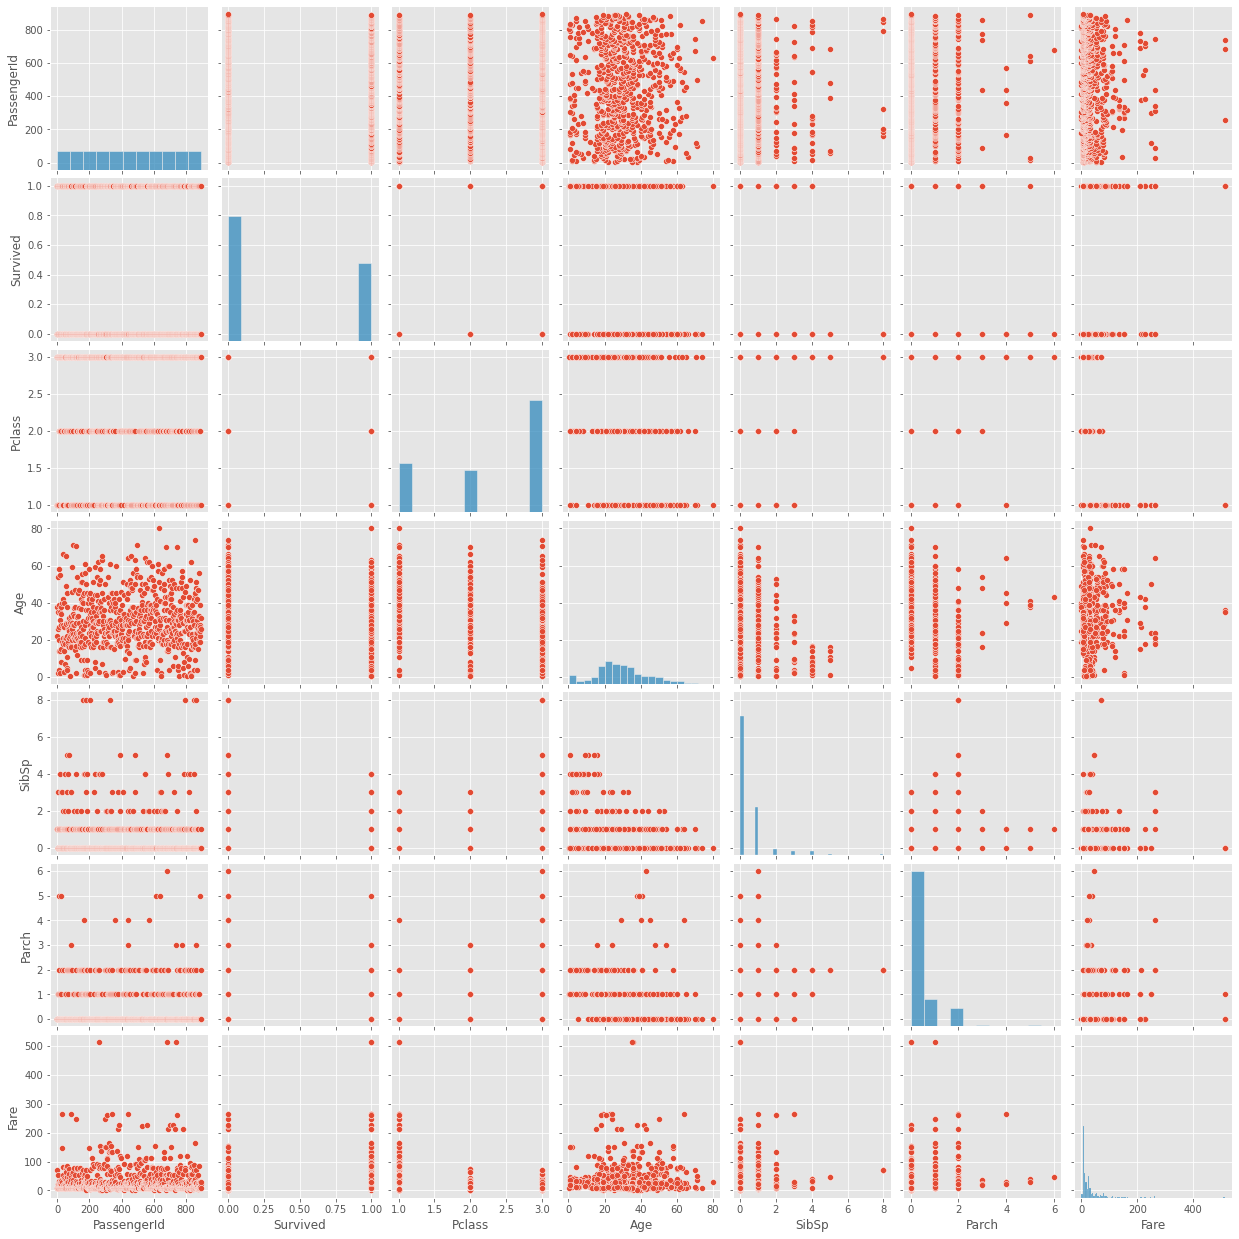

In [ ]:
sns.pairplot(train)

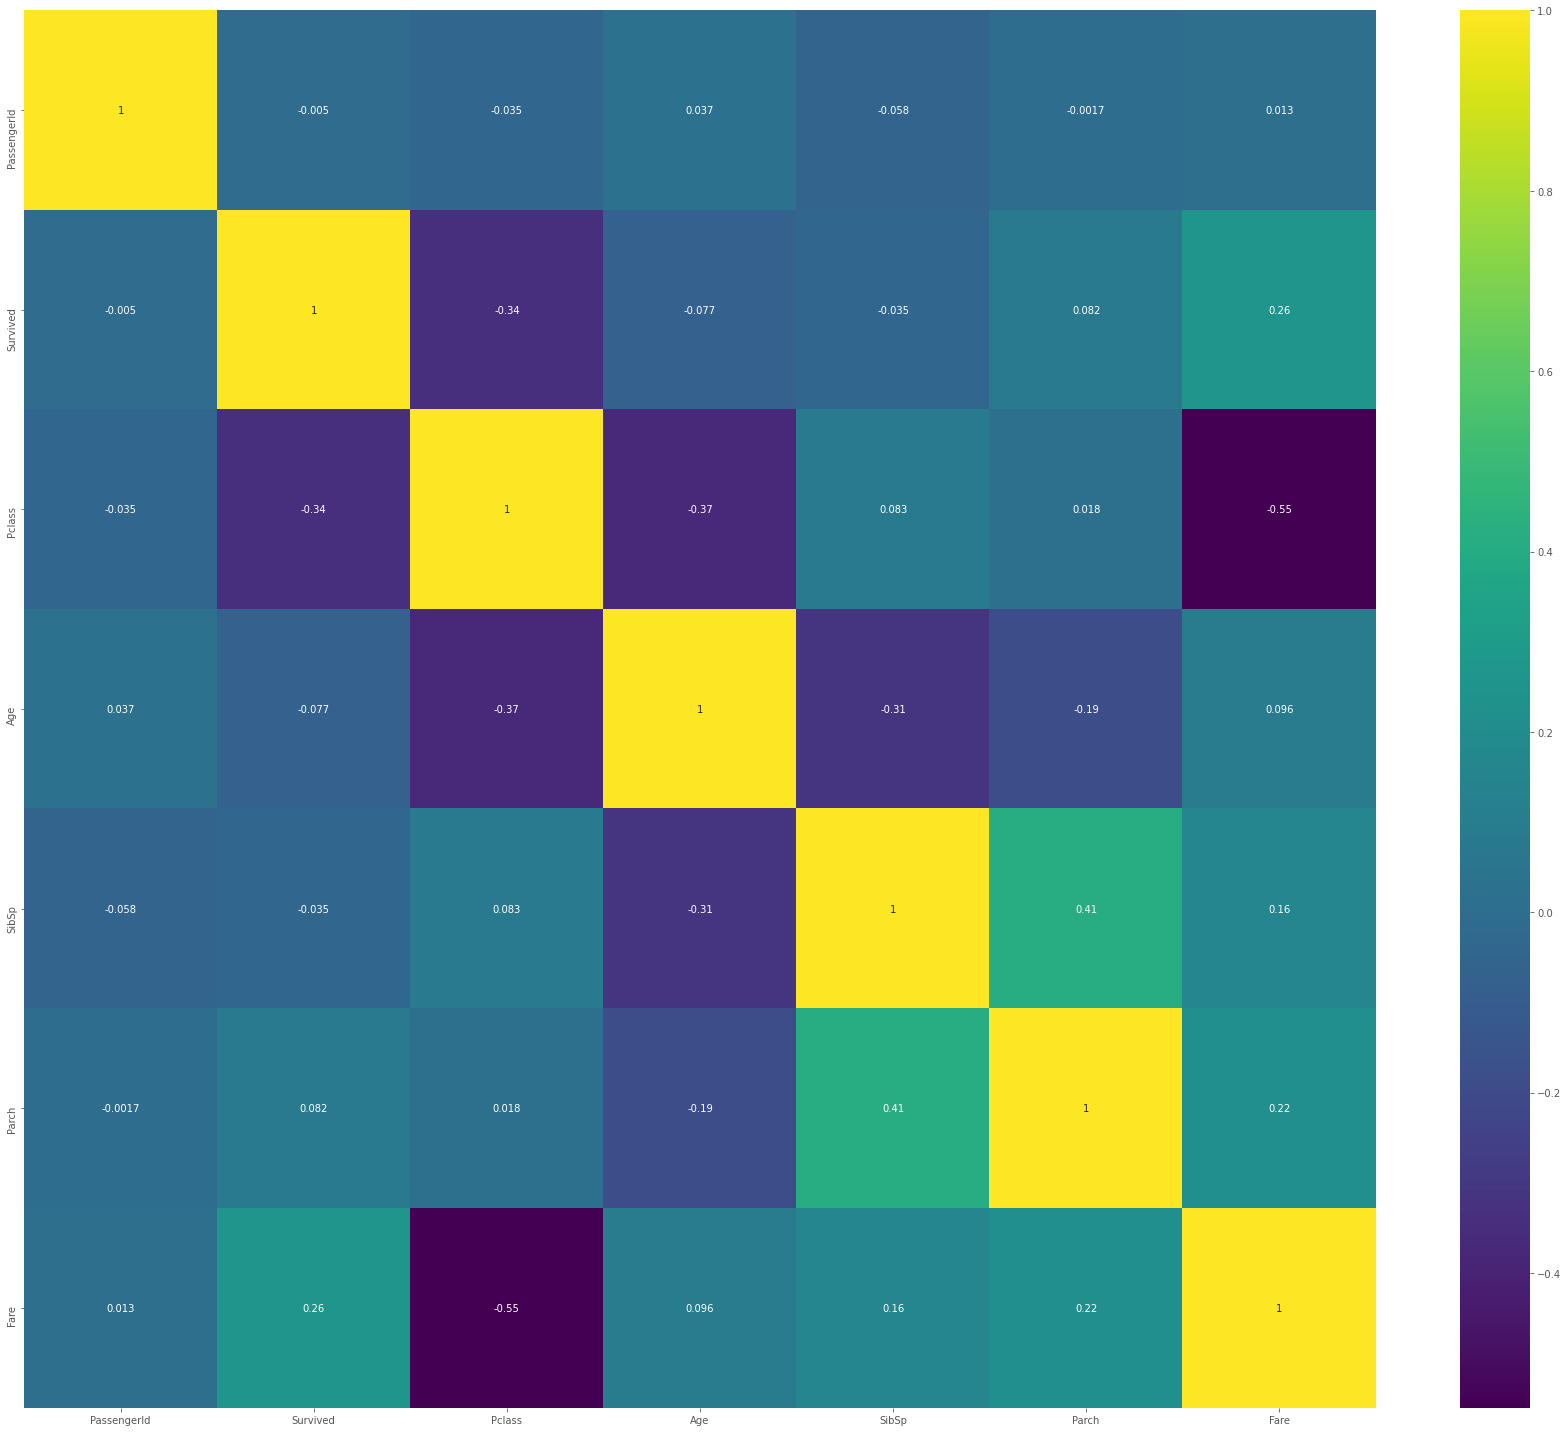

In [ ]:
plt.figure(figsize=(24,20))
corrmat = train.corr()
sns.heatmap(corrmat,annot=True,cmap="viridis")
plt.tight_layout()

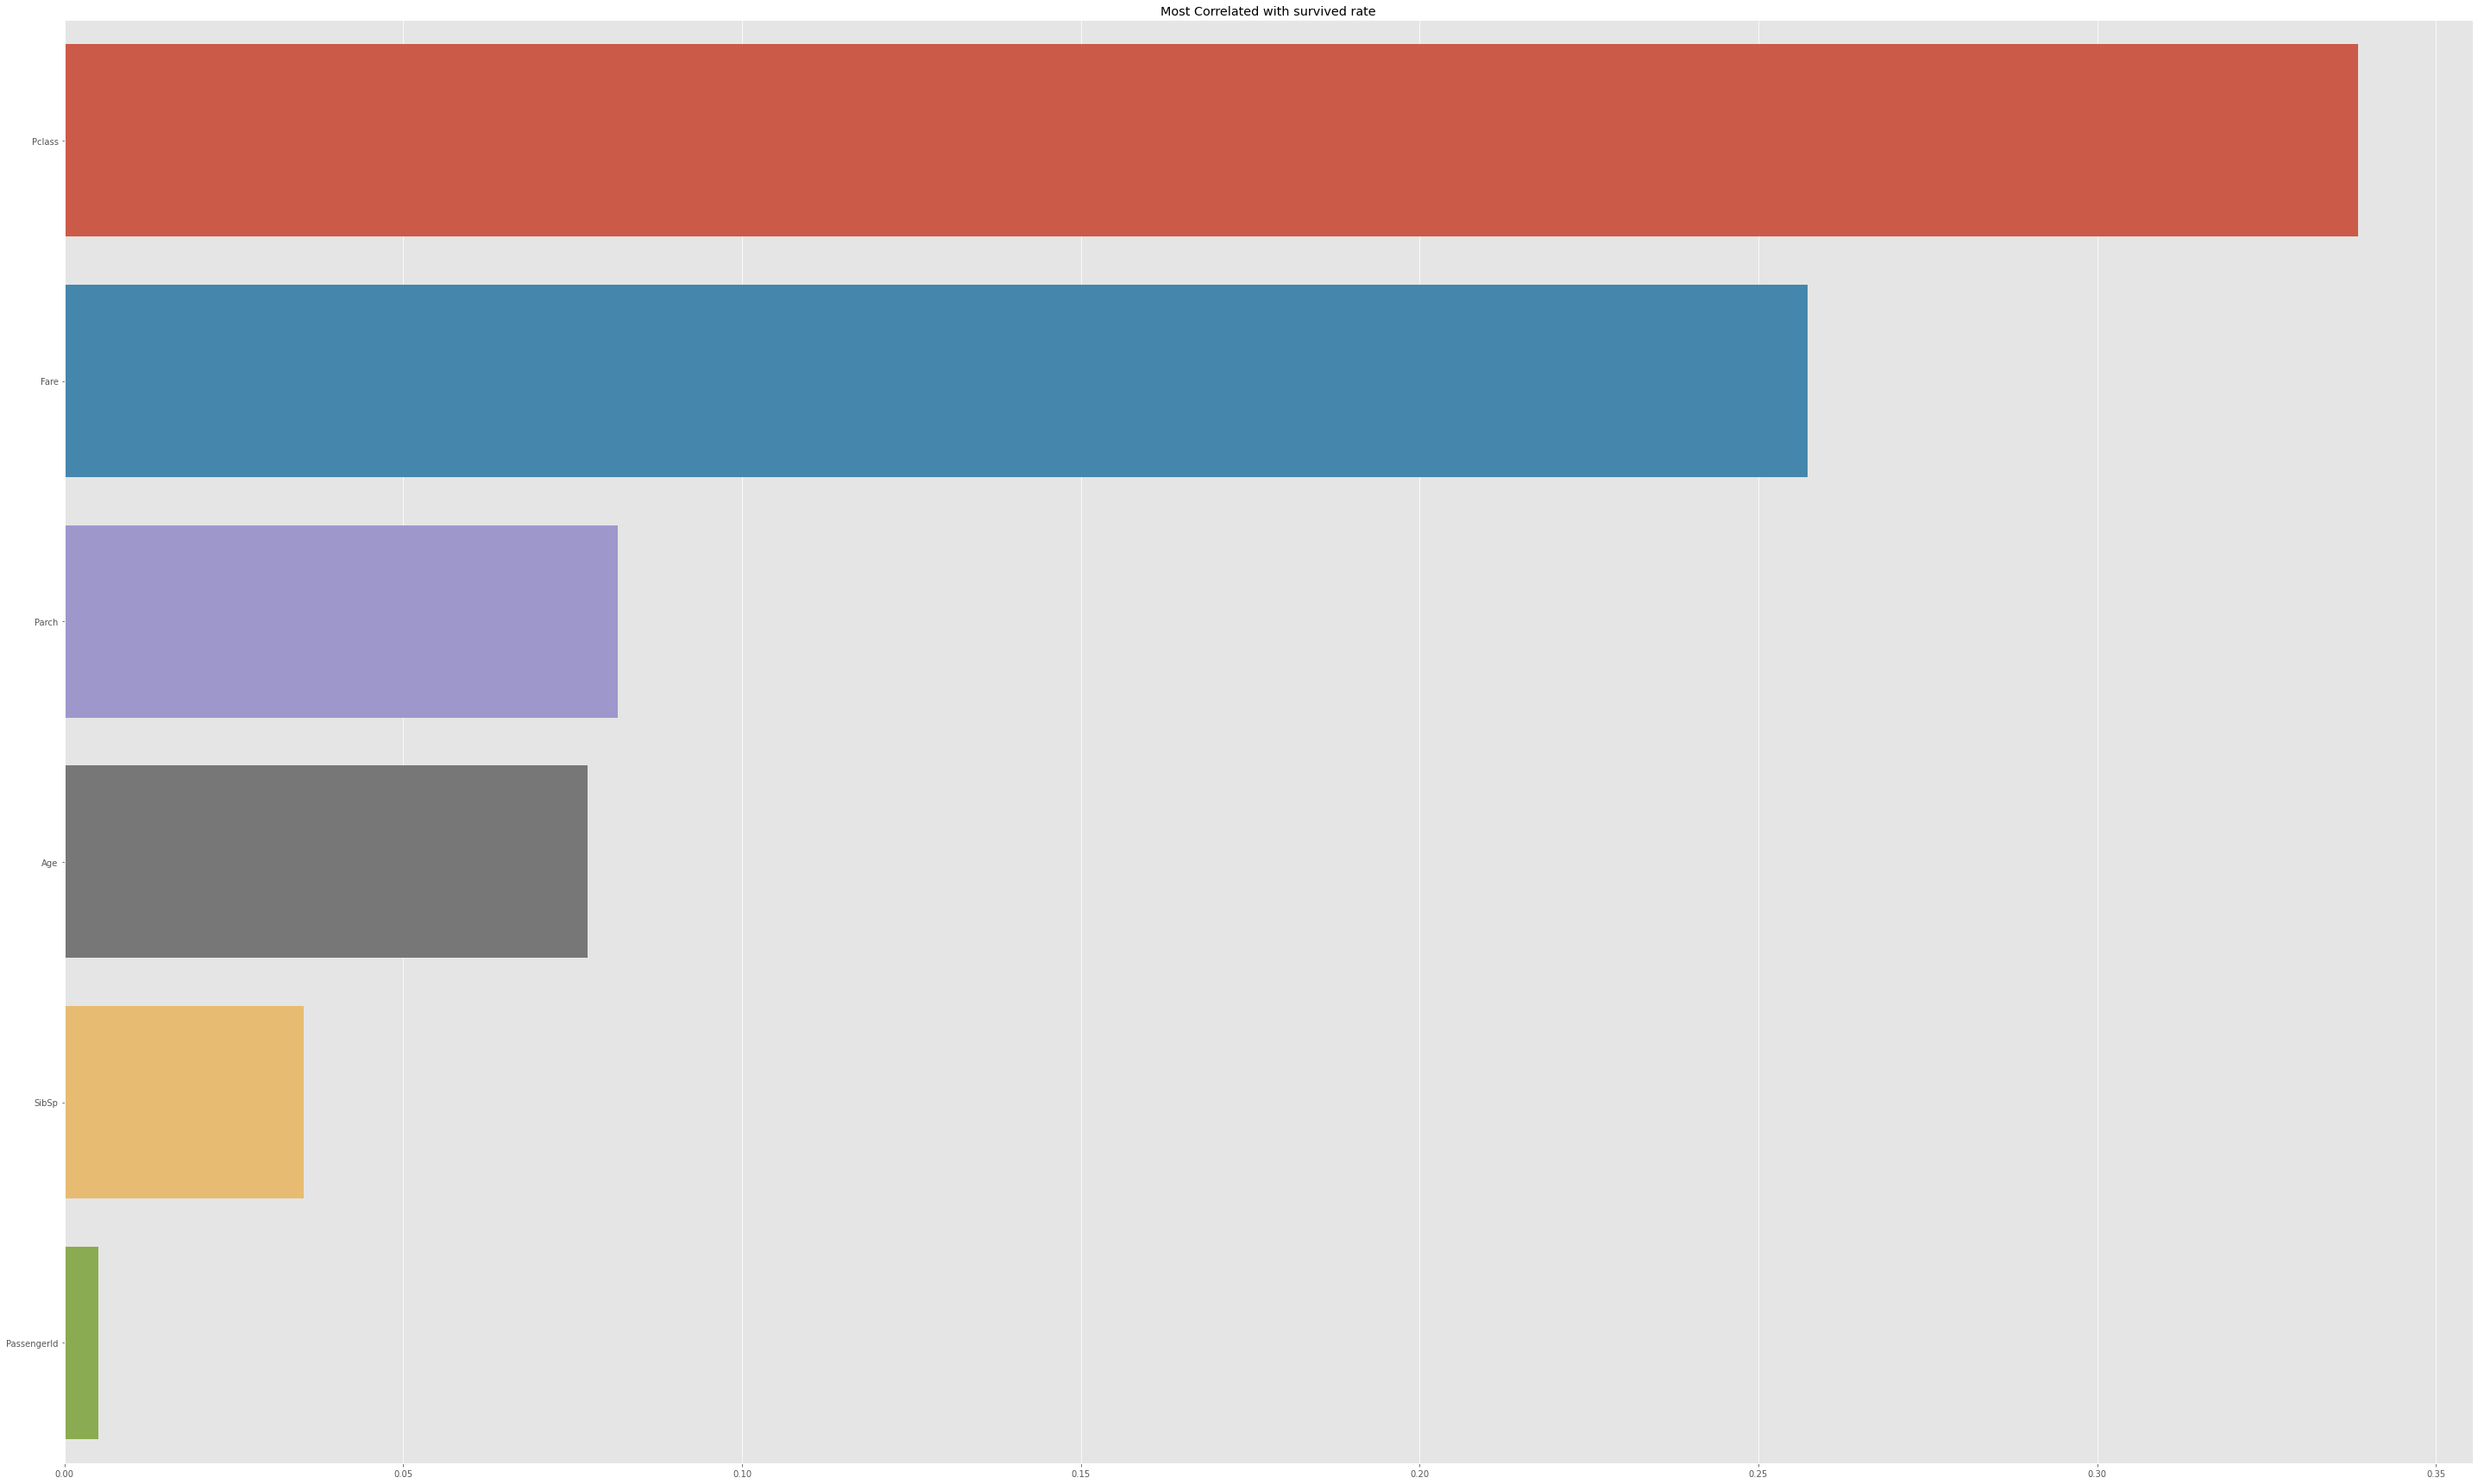

In [ ]:
plt.figure(figsize=(40,24))
correlations =corrmat.abs()['Survived'].sort_values(ascending=False)[1:]
ax = sns.barplot(x=correlations.values,y=correlations.index).set_title('Most Correlated with survived rate')
plt.tight_layout()

<Figure size 1152x576 with 0 Axes>

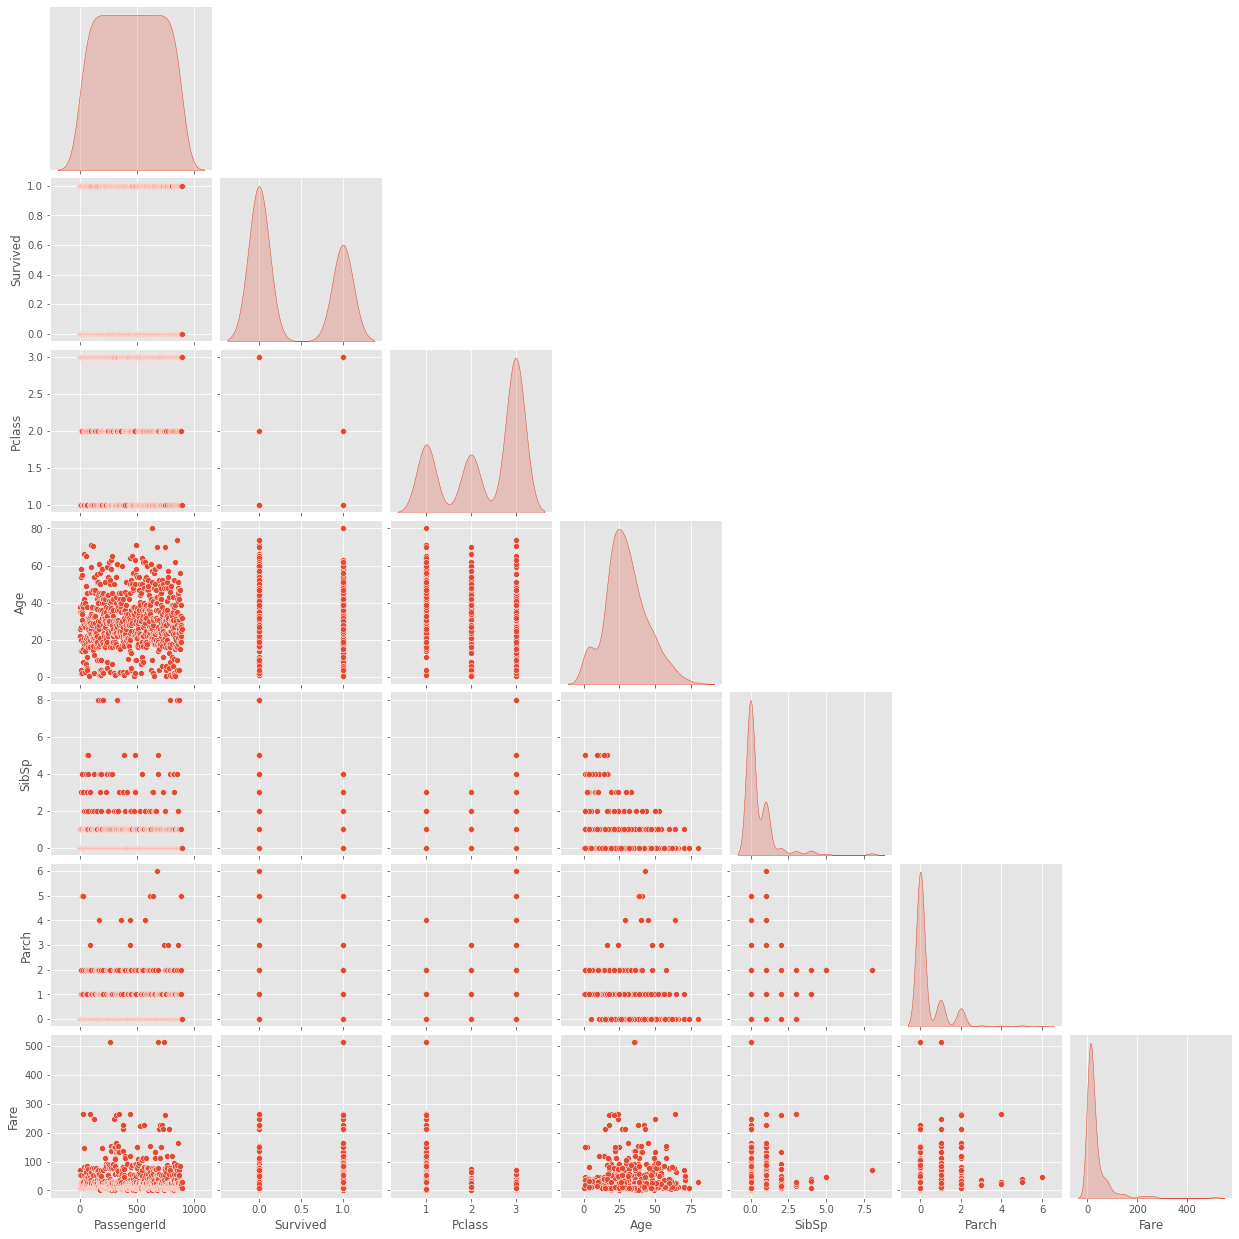

In [ ]:
plt.figure(figsize=(16,8))
sns.pairplot(train,diag_kind= "kde",corner= True)

### Features Engenering

In [ ]:
train['Age'].fillna(train['Age'].dropna().median(),inplace = True)
test['Age'].fillna(test['Age'].dropna().median(),inplace = True)

In [ ]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [ ]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [ ]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [ ]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1


In [ ]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [ ]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [ ]:
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,3,2,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,1,1,1
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,3,3,0


In [ ]:
freq_port = train.Embarked.dropna().mode()[0]
freq_port

'S'

In [ ]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [ ]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,3,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,2,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,3,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,1


## Mode and Predictions

In [ ]:
std1 = StandardScaler()
std2 = StandardScaler()

std3 = StandardScaler()
std4 = StandardScaler()

train['AgeStd'] = std1.fit_transform(train['Age'].values.reshape(-1,1))
train['FareStd'] = std2.fit_transform(train['Fare'].values.reshape(-1,1))

test['AgeStd'] = std3.fit_transform(test['Age'].values.reshape(-1,1))
test['FareStd'] = std4.fit_transform(test['Fare'].values.reshape(-1,1))

In [ ]:
train.dropna(inplace = True)
X = train.drop(['Name',"Survived","Ticket","Cabin","PassengerId","Fare","Age",'SibSp','Parch'], axis=1)
y = train["Survived"]


In [ ]:
X.head()

,Pclass,Sex,Embarked,Title,FamilySize,IsAlone,AgeStd,FareStd
1,1,1,1,3,2,0,0.663861,0.786845
3,1,1,0,3,2,0,0.433312,0.420730
6,1,0,0,1,1,1,1.893459,0.395814
10,3,1,0,2,3,0,-1.949034,-0.312172
11,1,1,0,2,1,1,2.200858,-0.113846


In [ ]:
X_train, X_test, y_train, y_test = ml.tts_split(X.values,y.values,0.3,5)

In [ ]:
lr = ml.Class_Fit(clf = LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,60),'penalty': ["l2","elasticnet","none"],'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}], Kfold = 10)
lr.grid_fit(X = X_train, Y = y_train)
lr.grid_predict(X_test, y_test)

Precision: 83.78 %  
 ROC Score: 0.75
Accuracy: 75.81 % 

               precision    recall  f1-score   support

           0       0.64      0.73      0.68        22
           1       0.84      0.78      0.81        40

    accuracy                           0.76        62
   macro avg       0.74      0.75      0.74        62
weighted avg       0.77      0.76      0.76        62



In [ ]:
g = plf.plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, y_train,
                        ylim = [1.01, 0.2], cv = 10, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [ ]:
tr = ml.Class_Fit(clf = DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 10)
tr.grid_fit(X = X_train, Y = y_train)
tr.grid_predict(X_test, y_test)

In [ ]:
g = plf.plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, y_train,
                        ylim = [1.01, 0.7], cv = 10, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [ ]:
rf = ml.Class_Fit(clf = RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 10)
rf.grid_fit(X = X_train, Y = y_train)
rf.grid_predict(X_test, y_test)

In [ ]:
g = plf.plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, y_train,
                        ylim = [1.01, 0.7], cv = 10, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [ ]:
et = ml.Class_Fit(clf = ExtraTreesClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],'criterion' : ['entropy', 'gini'],'max_features' :['sqrt', 'log2']}
et.grid_search(parameters = param_grid, Kfold = 10)
et.grid_fit(X = X_train, Y = y_train)
et.grid_predict(X_test, y_test)

Precision: 86.05 %  
 ROC Score: 0.83
Accuracy: 85.48 % 

               precision    recall  f1-score   support

           0       0.84      0.73      0.78        22
           1       0.86      0.93      0.89        40

    accuracy                           0.85        62
   macro avg       0.85      0.83      0.84        62
weighted avg       0.85      0.85      0.85        62



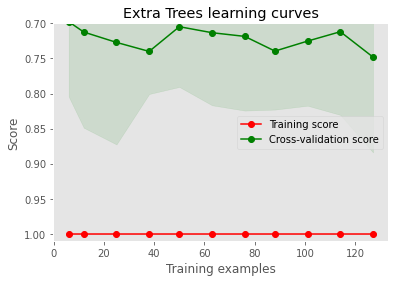

In [ ]:
g = plf.plot_learning_curve(et.grid.best_estimator_, "Extra Trees learning curves", X_train, y_train,
                        ylim = [1.01, 0.7], cv = 10, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [ ]:
ada = ml.Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 10)
ada.grid_fit(X = X_train, Y = y_train)
ada.grid_predict(X_test, y_test)

Precision: 77.55 %  
 ROC Score: 0.72
Accuracy: 79.03 % 

               precision    recall  f1-score   support

           0       0.85      0.50      0.63        22
           1       0.78      0.95      0.85        40

    accuracy                           0.79        62
   macro avg       0.81      0.72      0.74        62
weighted avg       0.80      0.79      0.77        62



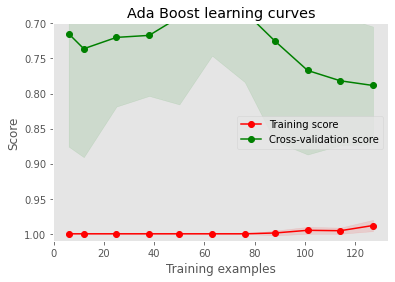

In [ ]:
g = plf.plot_learning_curve(ada.grid.best_estimator_, "Ada Boost learning curves", X_train, y_train,
                        ylim = [1.01, 0.7], cv = 10, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [ ]:
gb = ml.Class_Fit(clf = GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 10)
gb.grid_fit(X = X_train, Y = y_train)
gb.grid_predict(X_test, y_test)

Precision: 82.93 %  
 ROC Score: 0.77
Accuracy: 79.03 % 

               precision    recall  f1-score   support

           0       0.71      0.68      0.70        22
           1       0.83      0.85      0.84        40

    accuracy                           0.79        62
   macro avg       0.77      0.77      0.77        62
weighted avg       0.79      0.79      0.79        62



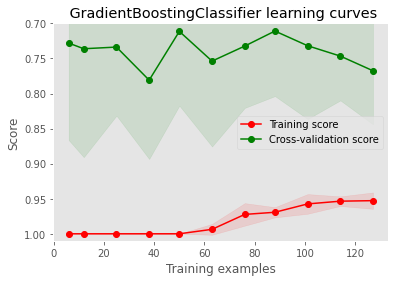

In [ ]:
g = plf.plot_learning_curve(gb.grid.best_estimator_, " GradientBoostingClassifier learning curves", X_train, y_train,
                        ylim = [1.01, 0.7], cv = 10, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [ ]:
rf_best  = RandomForestClassifier(**rf.grid.best_params_)
gb_best  = GradientBoostingClassifier(**gb.grid.best_params_)
tr_best  = DecisionTreeClassifier(**tr.grid.best_params_)
lr_best  = LogisticRegression(**lr.grid.best_params_)
et_best = ExtraTreesClassifier(**et.grid.best_params_)

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
stacking = StackingClassifier(estimators=[('rf', rf_best),('tr', tr_best),('et',et_best),
                                                ('lr', lr_best)],
                            final_estimator =gb_best,passthrough = True, cv =10,n_jobs = -1)

In [ ]:
stacking = stacking.fit(X_train, y_train)

In [ ]:
predictions = stacking.predict(X_test)
print("Accuracy: {:.2f} % ".format(100*accuracy_score(y_test, predictions)))
print("Precision: {:.2f} % ".format(100*precision_score(y_test, predictions)))

Accuracy: 77.42 % 
Precision: 82.50 % 


In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [ ]:
model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, validation_split=0.2, batch_size=8, epochs=30, shuffle=True, verbose=2)

Epoch 1/30
15/15 - 1s - loss: 0.9538 - accuracy: 0.3540 - val_loss: 0.7618 - val_accuracy: 0.4483
Epoch 2/30
15/15 - 0s - loss: 0.7026 - accuracy: 0.5575 - val_loss: 0.6168 - val_accuracy: 0.6207
Epoch 3/30
15/15 - 0s - loss: 0.6224 - accuracy: 0.6637 - val_loss: 0.5512 - val_accuracy: 0.6552
Epoch 4/30
15/15 - 0s - loss: 0.5952 - accuracy: 0.6814 - val_loss: 0.5306 - val_accuracy: 0.6897
Epoch 5/30
15/15 - 0s - loss: 0.5902 - accuracy: 0.6814 - val_loss: 0.5235 - val_accuracy: 0.6897
Epoch 6/30
15/15 - 0s - loss: 0.5831 - accuracy: 0.6814 - val_loss: 0.5215 - val_accuracy: 0.6897
Epoch 7/30
15/15 - 0s - loss: 0.5759 - accuracy: 0.6814 - val_loss: 0.5228 - val_accuracy: 0.6897
Epoch 8/30
15/15 - 0s - loss: 0.5696 - accuracy: 0.6726 - val_loss: 0.5189 - val_accuracy: 0.6897
Epoch 9/30
15/15 - 0s - loss: 0.5639 - accuracy: 0.6726 - val_loss: 0.5180 - val_accuracy: 0.6552
Epoch 10/30
15/15 - 0s - loss: 0.5606 - accuracy: 0.6637 - val_loss: 0.5205 - val_accuracy: 0.6897
Epoch 11/30
15/15 -

In [ ]:
fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X_train,y_train)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 500 

#intializing lgbm and lunching the search
lgbm_clf = lgbm.LGBMClassifier(random_state=None, silent=True, metric='None', n_jobs=-1)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=None,
    verbose=True)

grid_search.fit(X, y, **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score reached: 0.6667073170731708 with params: {'colsample_bytree': 0.7336555399773104, 'learning_rate': 0.4, 'max_depth': 6, 'min_child_samples': 392, 'min_child_weight': 0.1, 'n_estimators': 300, 'num_leaves': 30, 'reg_alpha': 50, 'reg_lambda': 0.1, 'subsample': 0.8348470922531199} 


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   33.5s finished


In [ ]:
def model_performance(model) : 
    y_valid = y_test
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_valid, y_score) , 3)
    fpr, tpr, t = roc_curve(y_valid, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_valid, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    #Feature importance
    coefficients  = pd.DataFrame(eval(model).feature_importances_)
    column_data   = pd.DataFrame(list(train))
    coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
    trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients", 
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6,color = "black")))
    
    #Cumulative gain
    pos = pd.get_dummies(y_valid).values
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_valid.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=4, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                          'Precision - Recall curve',
                                          'Cumulative gains curve',
                                          'Feature importance'
                                          ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                         autosize = False, 
                         height = 1500,
                         width = 800,
                         plot_bgcolor = 'black',
                         paper_bgcolor = 'black',
                         margin = dict(b = 195), 
                         font=dict(color='white')
                        )
    
    fig["layout"]["xaxis1"].update(dict(color = 'white'),showgrid=False)
    fig["layout"]["yaxis1"].update(dict(color = 'white'),showgrid=False)
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')),showgrid=False)
    fig["layout"]["yaxis2"].update(dict(color = 'white'),showgrid=False)
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"),showgrid=False)
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white',showgrid=False)
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white',showgrid=False)
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white',showgrid=False)
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"),color = 'white',showgrid=False)
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"),color = 'white',showgrid=False)
    fig["layout"]["xaxis6"].update(dict(color = 'white'),showgrid=False)
    fig["layout"]["yaxis6"].update(dict(color = 'white'),showgrid=False)
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)

In [ ]:
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]

model_performance('lgbm_clf')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
res = []
for sc in scores:
    scores = cross_val_score(lgbm_clf, X, y, cv = 5, scoring = sc)
    #print(sc, scores)
    res.append(scores)
df = pd.DataFrame(res).T
df.loc['mean'] = df.mean()
df.loc['std'] = df.std()
df= df.rename(columns={0: 'accuracy', 1:'precision', 2:'recall',3:'f1',4:'roc_auc'})

trace = go.Table(
    header=dict(values=['<b>Fold', '<b>Accuracy', '<b>Precision', '<b>Recall', '<b>F1 score', '<b>Roc auc'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['center'],
                font = dict(size = 15)),
    cells=dict(values=[('1','2','3','4','5','mean', 'std'),
                       np.round(df['accuracy'],4),
                       np.round(df['precision'],4),
                       np.round(df['recall'],4),
                       np.round(df['f1'],4),
                       np.round(df['roc_auc'],4)],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['center'], font = dict(size = 15)))

layout = dict(width=800, height=400, title = '<b>Cross validation - 5 folds', font = dict(size = 15))
fig = dict(data=[trace], layout=layout)
py.iplot(fig, filename = 'styled_table')

In [ ]:
new_test = test.drop(['Name',"Ticket",'FamilySize',"Cabin","PassengerId","Fare","Age",'SibSp','Parch'], axis=1)
new_test.head()

,Pclass,Sex,Embarked,Title,IsAlone,AgeStd,FareStd
0,3,0,2,1,1,0.386231,-0.497413
1,3,1,0,3,0,1.371370,-0.512278
2,2,0,2,1,1,2.553537,-0.464100
3,3,0,0,1,1,-0.204852,-0.482475
4,3,1,0,3,0,-0.598908,-0.417492


In [ ]:
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)
lgbm_clf.fit(X, y)
Y_pred = model.predict_classes(new_test)

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)